PROJECT CODE

TASKS:

1_Expansão com hidrolases - MEME and BLAST
2_Features - NS Machine learning - Clustering and Kmers
3_Functional Analysis - MOFA 
4_Estructural - Ensemble 

O que posso aplicar para a generalidade dos casos?


In [37]:
# Blast

from Bio.Blast.Applications import NcbiblastpCommandline

# Arquivos de entrada
initial_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/initial_sequences.fasta"
new_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/new_sequences.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/blast_results.tsv"

# Remover o arquivo de saída, se existir
if os.path.exists(output_file):
    os.remove(output_file)

# Executar o BLAST usando o package do Anaconda e gravar os resultados no arquivo blast_results.tsv
blastp_cline = NcbiblastpCommandline(query=new_sequences_file, subject=initial_sequences_file, outfmt=6, out=output_file)
stdout, stderr = blastp_cline()


In [18]:
#MEME


# Arquivos de entrada
initial_sequences_file = "/Users/Sergiomendes/Desktop/Project/data/meme_input/merge.fasta"
output_file = "/Users/Sergiomendes/Desktop/Project/data/meme_output"

import subprocess

# Comando para executar o programa meme e redirecionar a saída para o arquivo
command = ["/opt/local/bin/meme",initial_sequences_file, "-nmotifs", "3", "-oc", output_file]

# Executar o comando
subprocess.run(command)

print("Análise MEME concluída. Os resultados foram salvos no arquivo meme_results.txt.")



Análise MEME concluída. Os resultados foram salvos no arquivo meme_results.txt.


In [ ]:
# EXPANSÃO DO DATASET

import os
from Bio import SeqIO
import requests
# Expandir o dataset negativo com mais casos negativos

# Define os termos de busca e filtra por proteínas da classe hidrolase
search_term = 'hidrolase'
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=protein&term={search_term}&retmax=100000'
search_result = requests.get(search_url).text
id_list = search_result.split('<Id>')[1:]
id_list = [id.split('</Id>')[0] for id in id_list]
print(id_list)

# Baixa as sequências das proteínas encontradas
fetch_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={id_list[0]}&rettype=fasta&retmode=text'
print(fetch_url)
print(requests.get(fetch_url).text)
output_file="/Users/Sergiomendes/Desktop/Project/data/notPET.fasta"

# Grava as sequências em um arquivo FASTA na pasta desejada
output_folder = '/Users/Sergiomendes/Desktop/Project/Code/data'
with open(output_file, 'w') as f:
    f.write(requests.get(fetch_url).text)

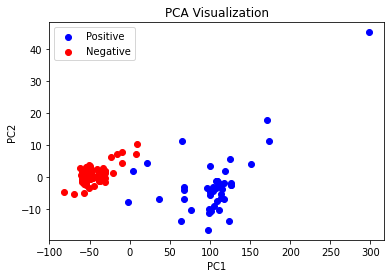

In [35]:
# Clustering
from Bio import SeqIO
import pandas as pd
from sklearn.decomposition import PCA

def extract_descriptors(sequence):
    # Replace this function with your own descriptor extraction logic for protein sequences
    # This is just a placeholder
    descriptor = [len(sequence), sequence.count('A'), sequence.count('C'),
                  sequence.count('D'), sequence.count('E'), sequence.count('F'),
                  sequence.count('G'), sequence.count('H'), sequence.count('I'),
                  sequence.count('K'), sequence.count('L'), sequence.count('M'),
                  sequence.count('N'), sequence.count('P'), sequence.count('Q'),
                  sequence.count('R'), sequence.count('S'), sequence.count('T'),
                  sequence.count('V'), sequence.count('W'), sequence.count('Y')]
    return descriptor

def create_dataframe(positive_file, negative_file):
    positive_sequences = list(SeqIO.parse(positive_file, 'fasta'))
    negative_sequences = list(SeqIO.parse(negative_file, 'fasta'))

    sequences = positive_sequences + negative_sequences
    labels = [0] * len(positive_sequences) + [1] * len(negative_sequences)
    descriptors = [extract_descriptors(str(seq.seq)) for seq in sequences]

    df = pd.DataFrame({'Label': labels, 'Descriptor': descriptors})
    return df

# Replace the filenames with your own
positive_file = '/Users/Sergiomendes/Desktop/Project/data/meme_input/initial_sequences.fasta'
negative_file = '/Users/Sergiomendes/Desktop/Project/data/notPET.fasta'

df = create_dataframe(positive_file, negative_file)

# Perform PCA
pca = PCA(n_components=2)  # Set n_components to 2
descriptors = df['Descriptor'].values.tolist()
pca_result = pca.fit_transform(descriptors)

# Add PCA results to DataFrame
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

# Visualize PCA results
labels = df['Label']
pc1 = df['PC1']
pc2 = df['PC2']

plt.scatter(pc1[labels == 0], pc2[labels == 0], c='blue', label='Positive')
plt.scatter(pc1[labels == 1], pc2[labels == 1], c='red', label='Negative')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization')
plt.legend()
plt.show()

In [ ]:
# FUNCTIONAL ANALYSIS - MOFA

import numpy as np
from mofapy2.mofapy2 import MOFA
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder

# Carregar as sequências de proteínas do arquivo initial_sequences.fasta
initial_sequences = []
with open(inicial_sequences_file, "r") as initial_seq_file:
    for record in SeqIO.parse(initial_seq_file, "fasta"):
        initial_sequences.append(str(record.seq))

# Carregar as sequências de proteínas do arquivo new_sequences.fasta
new_sequences = []
with open(new_sequences_file, "r") as new_seq_file:
    for record in SeqIO.parse(new_seq_file, "fasta"):
        new_sequences.append(str(record.seq))

# Codificar as sequências de proteínas usando One-Hot Encoding
encoder = OneHotEncoder(dtype=np.int8)
protein_sequences = initial_sequences + new_sequences
encoded_sequences = encoder.fit_transform(protein_sequences).toarray()

# Preparar as características funcionais relevantes 
# Certificar que as características funcionais estão no formato adequado (variáveis numéricas ou categóricas)

# Criar a matriz de dados para a análise MOFA
X = np.array(encoded_sequences)

# Configurar e executar o MOFA
model = MOFA()
model.set_data_matrix(X)
model.fit(n_factors=3)  # Definir o número de fatores latentes desejado

# Analisar os resultados do MOFA
factors = model.get_factors()
loadings = model.get_loadings()

# Exemplo de impressão dos resultados
for factor_idx, factor in enumerate(factors):
    print(f"Factor {factor_idx + 1}:")
    print(factor)
    print("")

for loading_idx, loading in enumerate(loadings):
    print(f"Loading {loading_idx + 1}:")
    print(loading)
    print("")



In [ ]:
# ESTRUCTURAL ANALYSIS - ENSEMBLE

In [34]:
# EXPANSÃO DO DATASET

import os
from Bio import SeqIO
import requests
# Expandir o dataset negativo com mais casos negativos

# Define os termos de busca e filtra por proteínas da classe hidrolase
search_term = 'hidrolase'
search_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=protein&term={search_term}&retmax=100000'
search_result = requests.get(search_url).text
id_list = search_result.split('<Id>')[1:]
id_list = [id.split('</Id>')[0] for id in id_list]
print(id_list)

# Baixa as sequências das proteínas encontradas
fetch_url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id={id_list[0]}&rettype=fasta&retmode=text'
print(fetch_url)
print(requests.get(fetch_url).text)
output_file="/Users/Sergiomendes/Desktop/Project/data/testNotPET.fasta"

# Grava as sequências em um arquivo FASTA na pasta desejada
output_folder = '/Users/Sergiomendes/Desktop/Project/Code/data'
with open(output_file, 'w') as f:
    f.write(requests.get(fetch_url).text)



['2192679634', '1200169718', '663497399']
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=protein&id=2192679634&rettype=fasta&retmode=text
>UKT59741.1 glycolsyl hidrolase family 10 [uncultured bacterium]
MRKYNFKLFIILPCIALFLFMFPAWDPKTTPPDTKPKETDLPLLYTKWPFPVGAAAPNSAFSPNNGQHDL
LNHFNVLVAENEMKPDALLPPSENGAYRWGNADALVNYAQAHNVKIRGHVLVWHNQTPAWFFAGSGADGL
ATKEQLYARMENHIKAVFEKYGGKIGWWDVCNEVVGDDGNPRAVTSSNYTAIMVNSGLKNLNRYEYVLMA
FQWARRYADANGGQNVKLYLNDYNIEYNGAKQSEFIKLVNWLIENDAPIDGIGIQCHIKWDWPSVAQISS
AIDKFSAISRKDGVKLMTQITELDMSLFSSNETDFNGGHILLTLPDVMRERRLPAQAKKYRELFDMFKIK
YEEKKLDMVLIWGLADGHSWLNNSPARGRTDYPLLFDRDYKPKQPYWELVK


